# Data Exploration for Intrusion Detection System

This notebook explores the network traffic dataset, performs exploratory data analysis, and visualizes attack patterns.


In [4]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# SOLUTION : On est dans notebooks/, src/ est dans le dossier parent
current_dir = os.getcwd()
print(f"📓 Notebook directory: {current_dir}")

# Remonter d'un niveau pour atteindre intelligent-ids/
project_root = os.path.dirname(current_dir)
print(f"🏠 Project root (intelligent-ids): {project_root}")

# Chemin vers src/
src_path = os.path.join(project_root, 'src')
print(f"🔍 Looking for src at: {src_path}")
print(f"✅ Exists: {os.path.exists(src_path)}")

if os.path.exists(src_path):
    print(f"📂 Contents of src/: {os.listdir(src_path)}")
    
    # OPTION 1: Ajouter project_root au path et importer avec src.
    if project_root not in sys.path:
        sys.path.insert(0, project_root)
    
    try:
        from src.preprocessing import DataPreprocessor
        from src.visualization import IDSVisualizer
        print("🎉 Import from src.preprocessing successful!")
    except ImportError as e:
        print(f"❌ Import error (option 1): {e}")
        
        # OPTION 2: Ajouter src_path au path et importer directement
        if src_path not in sys.path:
            sys.path.insert(0, src_path)
        
        try:
            from preprocessing import DataPreprocessor
            from visualization import IDSVisualizer
            print("🎉 Import direct from src/ successful!")
        except ImportError as e2:
            print(f"❌ Import error (option 2): {e2}")
            print("\n⚠️ Creating fallback classes...")
            
            # Créer des classes de secours
            class DataPreprocessor:
                def load_data(self, file_path):
                    """Load data from CSV file"""
                    print(f"📁 Loading: {file_path}")
                    
                    # Essayer le chemin relatif d'abord
                    if not os.path.exists(file_path):
                        # Essayer depuis la racine du projet
                        abs_path = os.path.join(project_root, file_path)
                        if os.path.exists(abs_path):
                            file_path = abs_path
                            print(f"  Found at: {file_path}")
                        else:
                            # Essayer depuis data/raw
                            data_path = os.path.join(project_root, 'data', 'raw', os.path.basename(file_path))
                            if os.path.exists(data_path):
                                file_path = data_path
                                print(f"  Found at: {file_path}")
                    
                    try:
                        df = pd.read_csv(file_path)
                        print(f"  ✅ Loaded: {len(df)} rows, {len(df.columns)} columns")
                        return df
                    except Exception as e:
                        print(f"  ❌ Error: {e}")
                        print("  Creating sample data...")
                        return pd.DataFrame({
                            'src_bytes': np.random.randint(0, 1000, 100),
                            'dst_bytes': np.random.randint(0, 1000, 100),
                            'duration': np.random.exponential(10, 100),
                            'protocol_type': np.random.choice(['tcp', 'udp', 'icmp'], 100),
                            'service': np.random.choice(['http', 'ftp', 'ssh'], 100),
                            'flag': np.random.choice(['SF', 'S0', 'REJ'], 100),
                            'label': np.random.randint(0, 2, 100)
                        })
            
            class IDSVisualizer:
                def __init__(self):
                    plt.style.use('seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else 'default')
                
                def plot_class_distribution(self, df, target_column='label'):
                    """Plot class distribution"""
                    plt.figure(figsize=(10, 6))
                    counts = df[target_column].value_counts()
                    
                    # Bar plot
                    ax = counts.plot(kind='bar', color=['lightblue', 'lightcoral'])
                    plt.title(f'Class Distribution ({target_column})')
                    plt.xlabel('Class')
                    plt.ylabel('Count')
                    plt.xticks(rotation=0)
                    
                    # Add labels on bars
                    for i, v in enumerate(counts):
                        ax.text(i, v, str(v), ha='center', va='bottom', fontweight='bold')
                    
                    plt.tight_layout()
                    plt.show()
                    
                    print(f"📊 Class distribution:\n{counts}")
                    print(f"\n📈 Class proportions:\n{counts / counts.sum():.2%}")
                    return counts
                
                def plot_feature_distributions(self, df, features, n_cols=3):
                    """Plot distributions of multiple features"""
                    n_features = len(features)
                    n_rows = (n_features + n_cols - 1) // n_cols
                    
                    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
                    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
                    
                    for i, feature in enumerate(features):
                        if i < len(axes):
                            axes[i].hist(df[feature].dropna(), bins=30, alpha=0.7, color='skyblue', edgecolor='black')
                            axes[i].set_title(f'Distribution: {feature}')
                            axes[i].set_xlabel(feature)
                            axes[i].set_ylabel('Frequency')
                    
                    # Hide empty subplots
                    for j in range(i+1, len(axes)):
                        axes[j].set_visible(False)
                    
                    plt.tight_layout()
                    plt.show()
                
                def plot_correlation_matrix(self, df, features):
                    """Plot correlation matrix"""
                    plt.figure(figsize=(12, 10))
                    
                    # Calculate correlation
                    corr_matrix = df[features].corr()
                    
                    # Create heatmap
                    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
                    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', 
                               center=0, fmt='.2f', square=True, linewidths=0.5)
                    
                    plt.title('Correlation Matrix', fontsize=16)
                    plt.tight_layout()
                    plt.show()
                
                def plot_attack_patterns(self, df, x_col, y_col, target_column='label'):
                    """Plot attack patterns"""
                    plt.figure(figsize=(12, 8))
                    
                    # Scatter plot with color by target
                    scatter = plt.scatter(df[x_col], df[y_col], 
                                         c=df[target_column], 
                                         alpha=0.6, 
                                         cmap='viridis',
                                         s=50)
                    
                    plt.colorbar(scatter, label=target_column)
                    plt.xlabel(x_col, fontsize=12)
                    plt.ylabel(y_col, fontsize=12)
                    plt.title(f'Attack Patterns: {x_col} vs {y_col}', fontsize=14)
                    plt.grid(True, alpha=0.3)
                    
                    plt.tight_layout()
                    plt.show()
else:
    print("❌ src directory not found!")

# Configuration d'affichage
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 10)

# Configuration des graphiques
try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('default')
sns.set_palette("husl")

print("\n" + "="*60)
print("✅ READY FOR DATA EXPLORATION!")
print("="*60)
print(f"Project structure:")
print(f"  {project_root}/")
print(f"  ├── src/           ← vos modules Python")
print(f"  ├── notebooks/     ← ce notebook")
print(f"  └── data/         ← vos données")
print("="*60)

📓 Notebook directory: c:\Users\ranar\Downloads\intelligent-ids\notebooks
🏠 Project root (intelligent-ids): c:\Users\ranar\Downloads\intelligent-ids
🔍 Looking for src at: c:\Users\ranar\Downloads\intelligent-ids\src
✅ Exists: True
📂 Contents of src/: ['alert_system.py', 'config.py', 'elk_integration.py', 'evaluation.py', 'feature_extraction.py', 'models.py', 'preprocessing.py', 'realtime_monitor.py', 'visualization.py', '__init__.py', '__pycache__']
🎉 Import from src.preprocessing successful!

✅ READY FOR DATA EXPLORATION!
Project structure:
  c:\Users\ranar\Downloads\intelligent-ids/
  ├── src/           ← vos modules Python
  ├── notebooks/     ← ce notebook
  └── data/         ← vos données


## 1. Load Data


In [5]:
# Load data
data_path = '../data/raw/UNSW_NB15_training-set.csv'  # Update with your dataset path

preprocessor = DataPreprocessor()
df = preprocessor.load_data(data_path)

if df is None:
    print("Creating sample data...")
    from src.preprocessing import main as create_sample
    create_sample()
    df = preprocessor.load_data(data_path)

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
df.head()


Data loaded: 175341 samples, 45 features
Dataset shape: (175341, 45)

Columns: ['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label']


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,252,2740.178955,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,Normal,0


## 2. Data Overview


In [6]:
# Basic statistics
print("Dataset Info:")
print(df.info())
print("\n" + "="*60)
print("\nBasic Statistics:")
print(df.describe())
print("\n" + "="*60)
print("\nMissing Values:")
print(df.isnull().sum())
print("\n" + "="*60)
print("\nData Types:")
print(df.dtypes)


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 175341 non-null  int64  
 1   dur                175341 non-null  float64
 2   proto              175341 non-null  object 
 3   service            175341 non-null  object 
 4   state              175341 non-null  object 
 5   spkts              175341 non-null  int64  
 6   dpkts              175341 non-null  int64  
 7   sbytes             175341 non-null  int64  
 8   dbytes             175341 non-null  int64  
 9   rate               175341 non-null  float64
 10  sttl               175341 non-null  int64  
 11  dttl               175341 non-null  int64  
 12  sload              175341 non-null  float64
 13  dload              175341 non-null  float64
 14  sloss              175341 non-null  int64  
 15  dloss              175341 non-null  i

## 3. Class Distribution


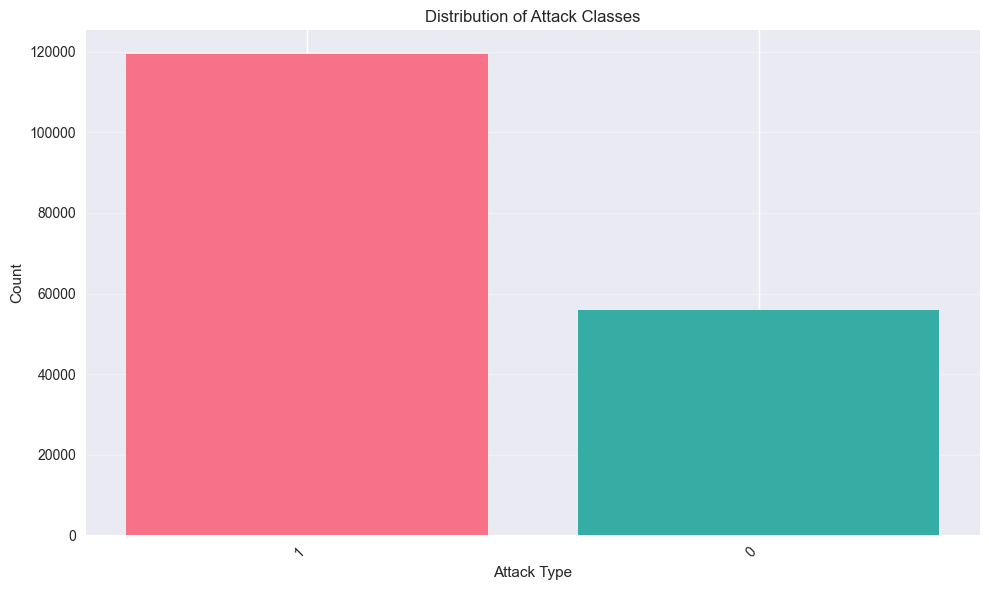


Class distribution:
label
1    119341
0     56000
Name: count, dtype: int64

Class proportions:
label
1    0.680622
0    0.319378
Name: proportion, dtype: float64


In [7]:
# Identify target column
target_col = None
for col in ['label', 'attack', 'class', 'target']:
    if col in df.columns:
        target_col = col
        break

if target_col:
    visualizer = IDSVisualizer()
    visualizer.plot_class_distribution(df, target_column=target_col)
    
    print("\nClass distribution:")
    print(df[target_col].value_counts())
    print(f"\nClass proportions:")
    print(df[target_col].value_counts(normalize=True))
else:
    print("Target column not found in dataset")


## 4. Feature Distributions


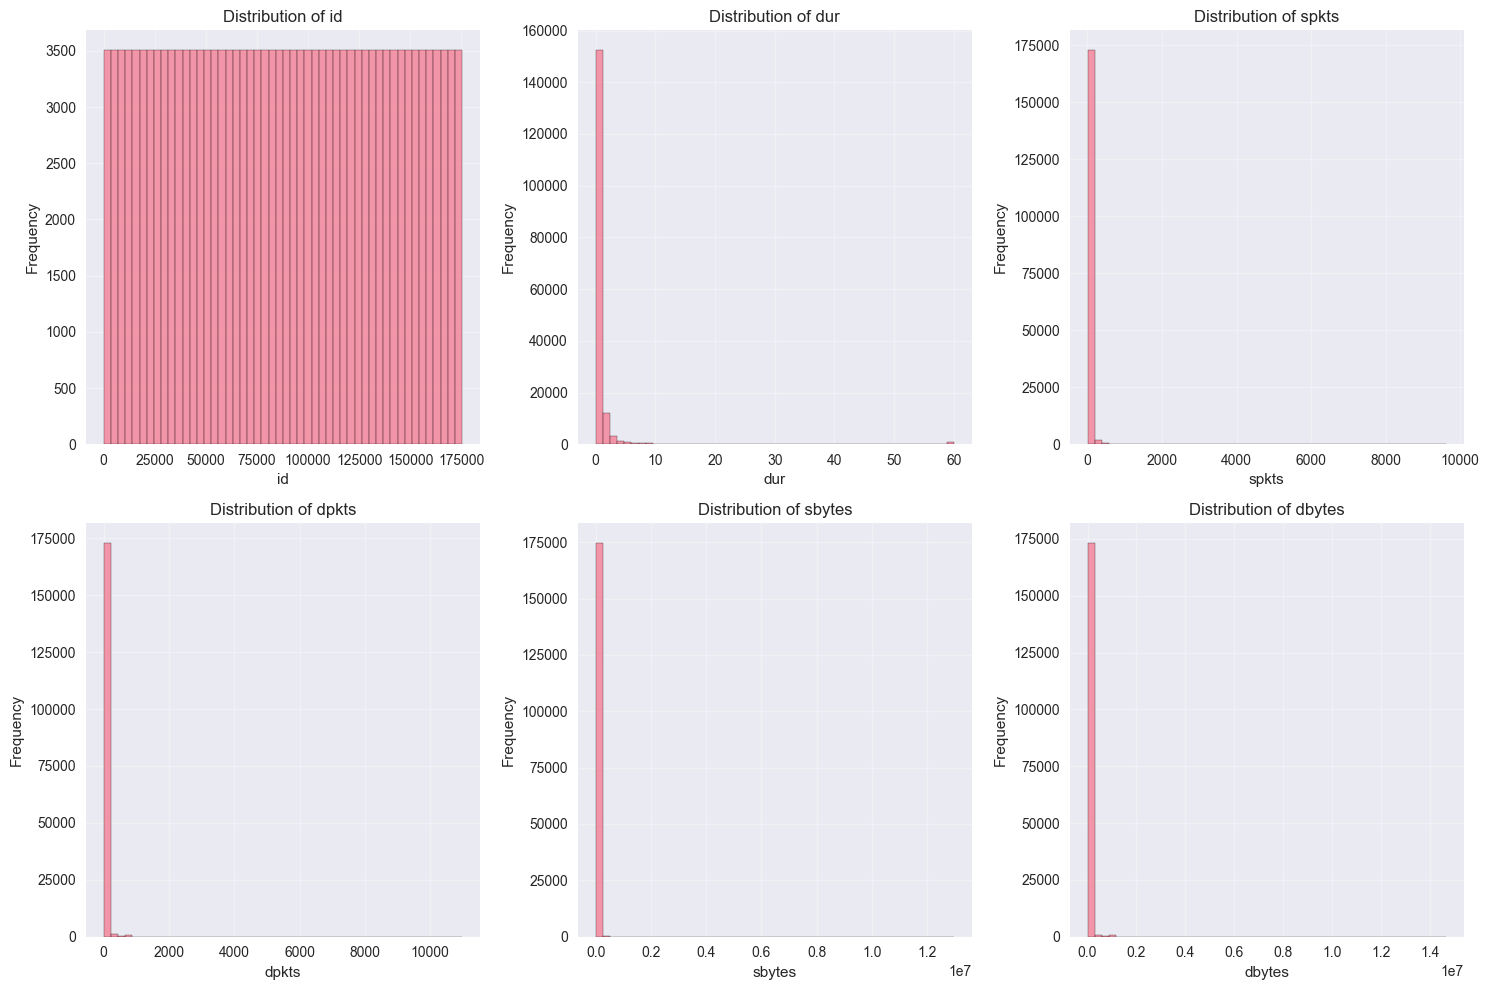

In [8]:
# Plot feature distributions
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col in numeric_cols:
    numeric_cols.remove(target_col)

if numeric_cols:
    visualizer.plot_feature_distributions(df, features=numeric_cols[:6])
else:
    print("No numeric features found")


## 5. Correlation Analysis


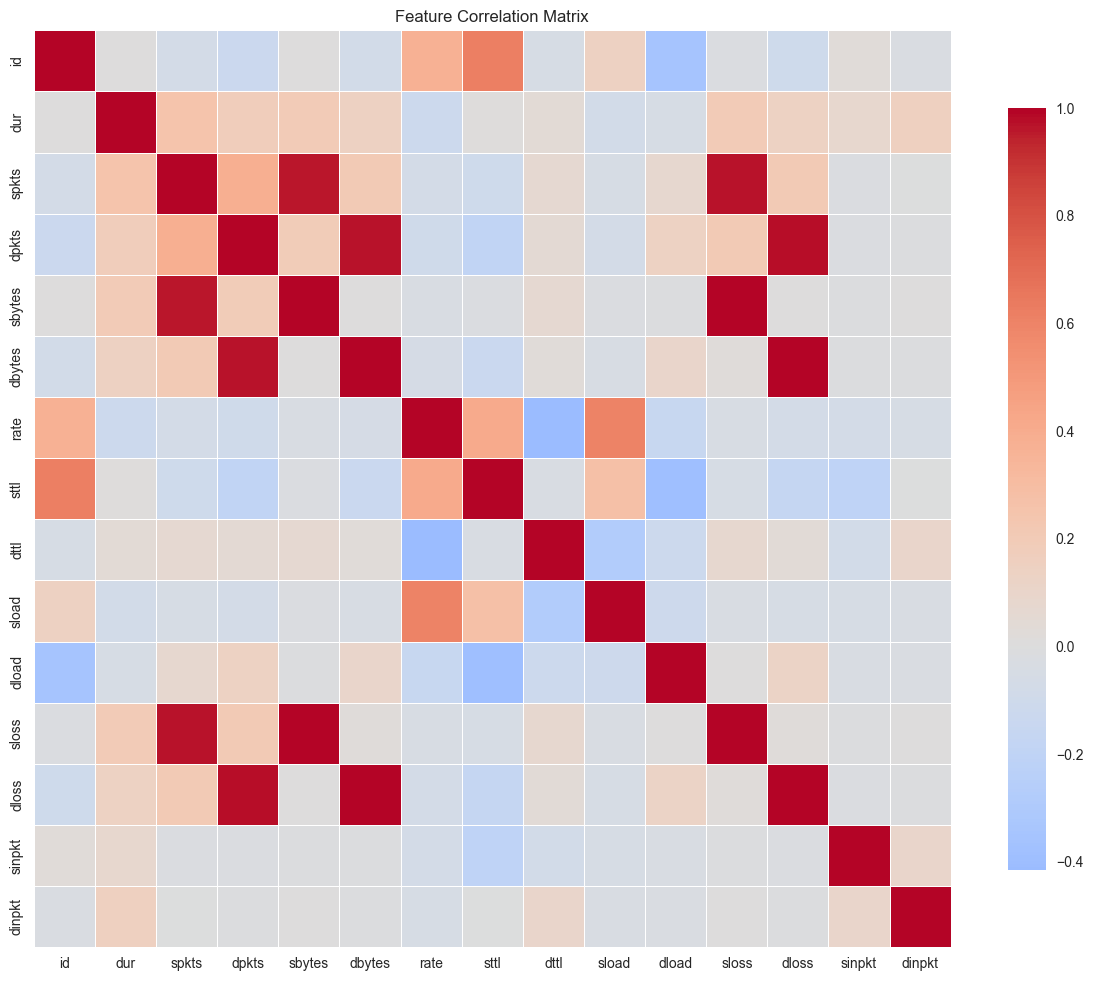

In [9]:
# Plot correlation matrix
if numeric_cols:
    visualizer.plot_correlation_matrix(df, features=numeric_cols[:15])


## 6. Attack Pattern Visualization


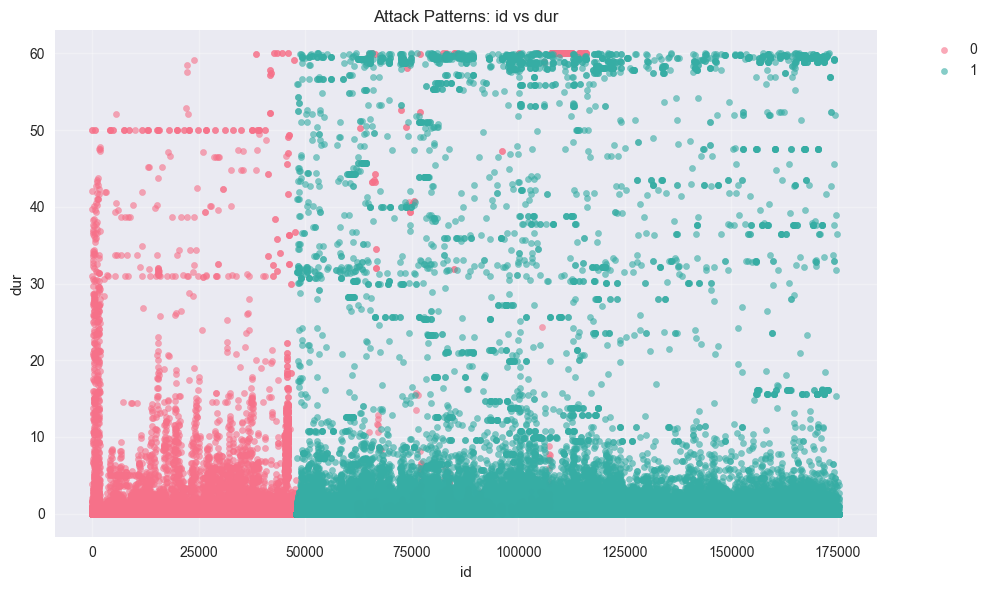

In [20]:
# Visualize attack patterns
if target_col and len(numeric_cols) >= 2:
    visualizer.plot_attack_patterns(
        df, 
        numeric_cols[0], 
        numeric_cols[1], 
        target_column=target_col
    )
